In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist.data, mnist.target


X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


In [18]:
mask_1 = (y_train == '1')
mask_7 = (y_train == '7')

# Combine the masks using a logical OR (|)
combined_mask = mask_1 | mask_7

mask_1t = (y_test == '1')
mask_7t = (y_test == '7')

# Combine the masks using a logical OR (|)
combined_mask_t = mask_1t | mask_7t

# Apply the combined mask to the full dataset (X and y)
X_train_required = X_train[combined_mask]
y_train_required = y_train[combined_mask]
X_test_required = X_test[combined_mask_t]
y_test_required = y_test[combined_mask_t]

print(f"Original X shape: {X_train.shape}")
print(f"Filtered X (1s and 7s) train shape: {X_train_required.shape}")
print(f"Original y shape: {y_train.shape}")
print(f"Filtered y (1s and 7s) train shape: {y_train_required.shape}")
print(f"Original X shape: {X_test.shape}")
print(f"Filtered X (1s and 7s) test shape: {X_test_required.shape}")
print(f"Original y shape: {y_test.shape}")
print(f"Filtered y (1s and 7s) test shape: {y_test_required.shape}")
print(f"\nUnique labels in new dataset: {np.unique(y_train_required)}")

Original X shape: (60000, 784)
Filtered X (1s and 7s) train shape: (13007, 784)
Original y shape: (60000,)
Filtered y (1s and 7s) train shape: (13007,)
Original X shape: (10000, 784)
Filtered X (1s and 7s) test shape: (2163, 784)
Original y shape: (10000,)
Filtered y (1s and 7s) test shape: (2163,)

Unique labels in new dataset: ['1' '7']


In [20]:
import matplotlib.pyplot as plt

In [22]:
num_train_images = X_train_required.shape[0]
num_samples = 20
random_indices = np.random.choice(num_train_images, num_samples, replace=False)

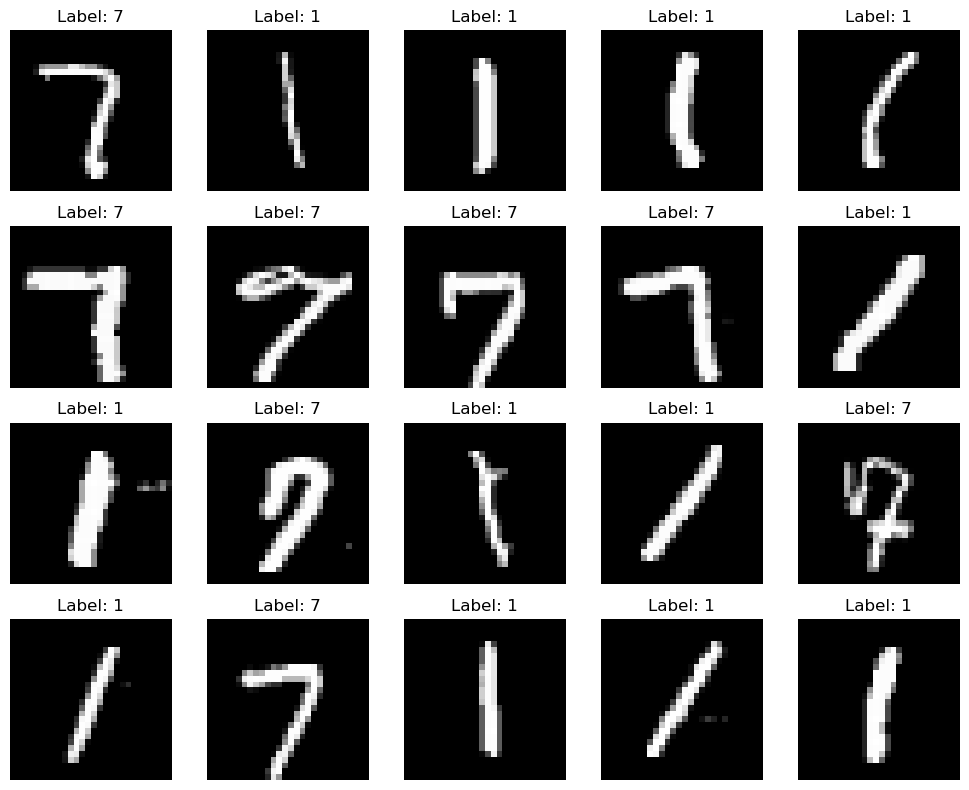

In [24]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

for i, ax in enumerate(axes.ravel()):
    idx = random_indices[i]
    image = X_train_required[idx]
    label = y_train_required[idx]

    image_reshaped = image.reshape(28, 28)

    ax.imshow(image_reshaped, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off') # Hide the x/y axes

plt.tight_layout()
plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler

# Create a scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train_required)

# Transform the test data using the *same* scaler
X_test_scaled = scaler.transform(X_test_required)

print("Data scaling complete.")
print(f"Original X_train mean: {np.mean(X_train_required):.2f}")
print(f"Scaled X_train mean: {np.mean(X_train_scaled):.2f}")
print(f"Scaled X_train std dev: {np.std(X_train_scaled):.2f}")

Data scaling complete.
Original X_train mean: 24.11
Scaled X_train mean: 0.00
Scaled X_train std dev: 0.91


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

In [30]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42)
}

In [32]:
results = {}

for name, model in models.items():
    print(f"--- Training {name} ---")
    start_time = time.time()
    
    # Use the correct dataset (scaled or unscaled)
    if name == 'Random Forest':
        # Random Forest doesn't need scaled data
        model.fit(X_train_required, y_train_required)
        y_pred = model.predict(X_test_required)
    else:
        # Other models use scaled data
        model.fit(X_train_scaled, y_train_required)
        y_pred = model.predict(X_test_scaled)
        
    end_time = time.time()
    
    # Calculate accuracy
    acc = accuracy_score(y_test_required, y_pred)
    results[name] = acc
    
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Time taken: {end_time - start_time:.2f} seconds\n")

--- Training Logistic Regression ---
Accuracy: 99.35%
Time taken: 0.32 seconds

--- Training K-Nearest Neighbors ---
Accuracy: 98.89%
Time taken: 0.42 seconds

--- Training Random Forest ---
Accuracy: 99.68%
Time taken: 2.41 seconds

--- Training Support Vector Machine ---
Accuracy: 98.94%
Time taken: 7.45 seconds



In [34]:
print("--- Final Model Comparison ---")
for name, acc in results.items():
    print(f"{name}: {acc * 100:.2f}%")

--- Final Model Comparison ---
Logistic Regression: 99.35%
K-Nearest Neighbors: 98.89%
Random Forest: 99.68%
Support Vector Machine: 98.94%


In [36]:
from sklearn.metrics import classification_report

rf_model = models['Random Forest']

y_pred_rf = rf_model.predict(X_test_required)

print("--- Classification Report for Random Forest ---")
print(f"Test Accuracy: {accuracy_score(y_test_required, y_pred_rf) * 100:.2f}%\n")

# This report shows precision, recall, and f1-score
report = classification_report(y_test_required, y_pred_rf, target_names=['Digit 1', 'Digit 7'])
print(report)

--- Classification Report for Random Forest ---
Test Accuracy: 99.68%

              precision    recall  f1-score   support

     Digit 1       1.00      1.00      1.00      1135
     Digit 7       1.00      1.00      1.00      1028

    accuracy                           1.00      2163
   macro avg       1.00      1.00      1.00      2163
weighted avg       1.00      1.00      1.00      2163



In [38]:
misclassified_indices = np.where(y_pred_rf != y_test_required)[0]

X_wrong = X_test_required[misclassified_indices]
y_true_wrong = y_test_required[misclassified_indices]
y_pred_wrong = y_pred_rf[misclassified_indices]

num_wrong = len(X_wrong)
print(f"Total misclassified images: {num_wrong}")

Total misclassified images: 7


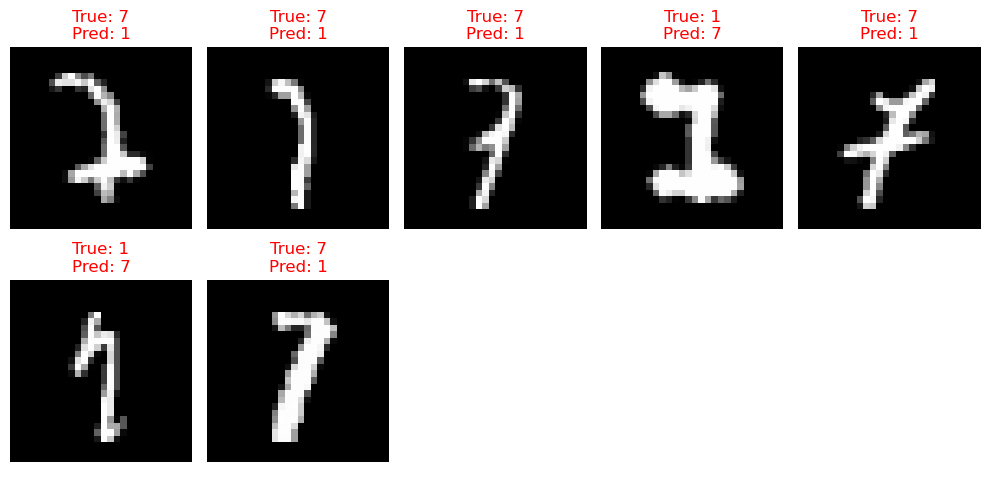

In [40]:
num_to_show = min(num_wrong, 20)
if num_to_show == 0:
    print("No images")
else:
    rows = (num_to_show + 4) // 5
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(10, 2.5 * rows))
    
    axes = axes.ravel()
    
    for i in range(num_to_show):
        image = X_wrong[i].reshape(28, 28)
        true_label = y_true_wrong[i]
        pred_label = y_pred_wrong[i]
        
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", color='red')
        axes[i].axis('off')
        
    for i in range(num_to_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

Model class order: ['1' '7']


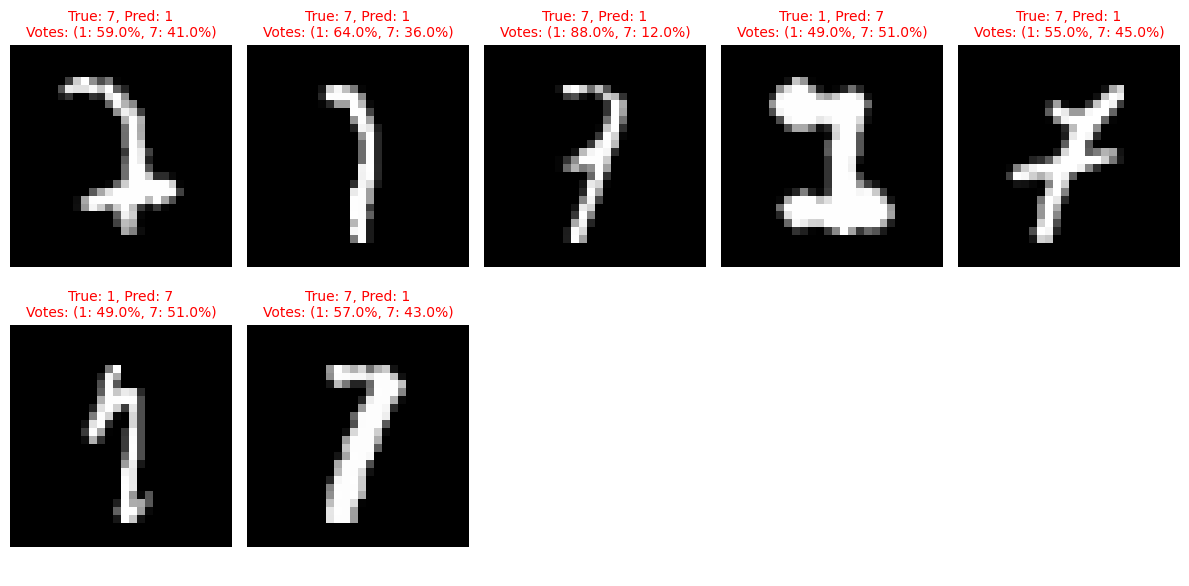

In [46]:
rf_model = models['Random Forest']

# This is crucial. 'classes_' will tell us if column 0 is '1' or '7'
class_labels = rf_model.classes_
print(f"Model class order: {class_labels}")

# Find which column index corresponds to '1' and '7'
label_1_index = np.where(class_labels == '1')[0][0]
label_7_index = np.where(class_labels == '7')[0][0]

all_probabilities = rf_model.predict_proba(X_test_required)

if 'misclassified_indices' not in locals():
    print("Error.")
else:
    wrong_probabilities = all_probabilities[misclassified_indices]

    num_wrong = len(misclassified_indices)
    num_to_show = min(num_wrong, 20)
    
    if num_to_show == 0:
        print("No images were misclassified")
    else:
        rows = (num_to_show + 4) // 5
        cols = 5
        fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
        axes = axes.ravel()
        
        for i in range(num_to_show):
            # Get the image, labels, and probabilities
            image = X_wrong[i].reshape(28, 28)
            true_label = y_true_wrong[i]
            pred_label = y_pred_wrong[i]
            
            # Get the specific probabilities for this image
            prob_for_1 = wrong_probabilities[i, label_1_index]
            prob_for_7 = wrong_probabilities[i, label_7_index]
            
            title = (
                f"True: {true_label}, Pred: {pred_label}\n"
                f"Votes: (1: {prob_for_1*100:.1f}%, 7: {prob_for_7*100:.1f}%)"
            )
            
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(title, color='red', fontsize=10)
            axes[i].axis('off')

        for i in range(num_to_show, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()